## Algoritmos para Bioinformatica

El objetivo del proyecto fue desarrollar un modelo computacional basado en Modelos Ocultos de Markov (HMM) que permita identificar conotoxinas de forma automática y precisa a partir de datos de secuencia alineadas, con el fin de facilitar la detección de péptidos bioactivos en conjuntos de datos transcriptómicos y proteómicos.


#### Importar librerias

In [ ]:
!pip install biopython --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gzip
import sys
import os
import re
import pickle
import numpy as np

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from pathlib import Path
from collections import defaultdict
from typing import Dict, Tuple, List, Optional, Union, Any

In [ ]:
def parse_fasta(file_path: str) -> List[str]:
    """
    Parsea archivos FASTA (normales o comprimidos)

    Returns:
        Lista de secuencias
    """
    sequences = []
    current_seq = []

    # Verificar si el archivo existe
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo {file_path} no existe")

    # Decidir si abrir como gz o normal
    opener = gzip.open if file_path.endswith('.gz') else open

    try:
        with opener(file_path, 'rt') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if current_seq:
                        sequences.append(''.join(current_seq))
                        current_seq = []
                else:
                    current_seq.append(line)

            # No olvidar la última secuencia
            if current_seq:
                sequences.append(''.join(current_seq))
    except Exception as e:
        raise Exception(f"Error al leer el archivo FASTA: {e}")

    # Verificación básica
    if not sequences:
        raise ValueError("No se encontraron secuencias en el archivo FASTA")

    print(f"Se leyeron {len(sequences)} secuencias del archivo FASTA")
    return sequences

def filter_alignment_columns(sequences: List[str], min_occupancy: float = 0.1) -> Tuple[List[str], List[int]]:
    """
    Filtra las columnas del alineamiento que tienen una ocupancia menor al umbral

    Args:
        sequences: Lista de secuencias alineadas
        min_occupancy: Fracción mínima de posiciones no-gap requerida (0-1)

    Returns:
        Tupla con (secuencias_filtradas, columnas_conservadas)
    """
    if not sequences:
        return [], []

    alignment_length = len(sequences[0])
    num_sequences = len(sequences)

    # Verificar que todas las secuencias tengan la misma longitud
    for i, seq in enumerate(sequences):
        if len(seq) != alignment_length:
            raise ValueError(f"La secuencia {i} tiene longitud {len(seq)}, pero debería ser {alignment_length}")

    print(f"Analizando alineamiento: {num_sequences} secuencias de longitud {alignment_length}")

    # Calcular ocupancia por columna
    occupancy = []
    for col in range(alignment_length):
        non_gaps = sum(1 for seq in sequences if seq[col] != '-')
        occupancy.append(non_gaps / num_sequences)

    # Identificar columnas a mantener
    columns_to_keep = [col for col, occ in enumerate(occupancy) if occ >= min_occupancy]

    # Filtrar secuencias
    filtered_sequences = []
    for seq in sequences:
        filtered_seq = ''.join(seq[col] for col in columns_to_keep)
        filtered_sequences.append(filtered_seq)

    print(f"Filtrado: de {alignment_length} columnas originales a {len(columns_to_keep)} columnas ({len(columns_to_keep)/alignment_length*100:.1f}%)")

    # Verificar la longitud promedio sin gaps después del filtrado
    avg_non_gaps = sum(sum(1 for char in seq if char != '-') for seq in filtered_sequences) / num_sequences
    print(f"Promedio de caracteres no-gap por secuencia: {avg_non_gaps:.1f} de {len(columns_to_keep)} ({avg_non_gaps/len(columns_to_keep)*100:.1f}%)")

    return filtered_sequences, columns_to_keep

# Construcción del Modelo Oculto de Markov (HMM)

In [ ]:
def build_hmm(sequences: List[str], pseudocount: float = 5.0, max_model_size: int = 1343) -> Tuple:
    """
    Construye las matrices de transición y emisión del HMM con estados Match, Insert y Delete.
    """

    # Validación de entrada
    if not sequences:
        raise ValueError("No se proporcionaron secuencias")

    alignment_length = len(sequences[0])

    # Si el alineamiento es demasiado grande, filtrar posiciones con alta ocupancia
    if alignment_length > max_model_size:
        print(f"Alineamiento muy grande ({alignment_length}), filtrando para mantener {max_model_size} posiciones")
        # Calcular ocupancia por columna
        column_occupancy = []
        for col in range(alignment_length):
            non_gaps = sum(1 for seq in sequences if seq[col] != '-')
            column_occupancy.append(non_gaps / len(sequences))

        # Seleccionar las columnas con mayor ocupancia
        cols_to_keep = sorted(range(alignment_length), key=lambda i: column_occupancy[i], reverse=True)[:max_model_size]
        cols_to_keep.sort()  # Reordenar para mantener el orden original

        # Filtrar secuencias
        filtered_sequences = []
        for seq in sequences:
            filtered_seq = ''.join(seq[col] for col in cols_to_keep)
            filtered_sequences.append(filtered_seq)

        sequences = filtered_sequences
        alignment_length = len(sequences[0])
        print(f"Alineamiento reducido a {alignment_length} posiciones")

    # Estados del HMM
    states = ['S', 'I0'] + \
             [f'M{i}' for i in range(1, alignment_length+1)] + \
             [f'I{i}' for i in range(1, alignment_length+1)] + \
             [f'D{i}' for i in range(1, alignment_length+1)] + \
             ['E']

    # Recolectar todos los aminoácidos únicos (excluyendo gaps explícitamente)
    amino_acids = set()
    for seq in sequences:
        amino_acids.update(char for char in seq if char != '-')

    # Verificar aminoácidos válidos
    standard_aas = set("ACDEFGHIKLMNPQRSTVWY")
    non_standard = amino_acids - standard_aas
    if non_standard:
        print(f"Advertencia: Se encontraron aminoácidos no estándar: {non_standard}")
        print("   Estos serán tratados como caracteres normales")

    # Convertir a lista ordenada para uso posterior
    amino_acids = sorted(amino_acids)

    # Inicializar contadores con pseudocounts
    trans_counts = defaultdict(lambda: defaultdict(lambda: pseudocount))
    match_emit_counts = defaultdict(lambda: defaultdict(lambda: pseudocount))
    ins_emit_counts = defaultdict(lambda: defaultdict(lambda: pseudocount))

    # Contar transiciones y emisiones
    print("Contando transiciones y emisiones...")

    try:
        for i, seq in enumerate(sequences):
            if i % 100 == 0:  # Mostrar progreso cada 100 secuencias
                print(f"Procesando secuencia {i}/{len(sequences)} ({i/len(sequences)*100:.1f}%)")

            # Verificar caracteres válidos
            invalid_chars = set(seq) - set('ACDEFGHIKLMNPQRSTVWY-')
            if invalid_chars:
                print(f"Secuencia {i} tiene caracteres no válidos: {invalid_chars}")
                # Limpiar la secuencia (reemplazar caracteres no válidos con '-')
                seq = ''.join(char if char in "ACDEFGHIKLMNPQRSTVWY-" else '-' for char in seq)

            prev_state = 'S'

            for pos, aa in enumerate(seq):
                pos_index = pos + 1  # Ajuste para índices basados en 1

                if aa == '-':
                    # Gap representa un estado Delete en la posición
                    current_state = f'D{pos_index}'
                else:
                    # Un aminoácido en la posición corresponde a un Match
                    current_state = f'M{pos_index}'
                    match_emit_counts[current_state][aa] += 1

                # Registrar transición
                trans_counts[prev_state][current_state] += 1
                prev_state = current_state

            # Transición al estado final
            trans_counts[prev_state]['E'] += 1

    except Exception as e:
        print(f"Error en secuencia {i}: {e}")
        raise

    # Inicializar la topología completa del modelo y calcular probabilidades
    print("Calculando matrices de probabilidad...")

    # Definir la estructura del HMM: qué transiciones son posibles
    valid_transitions = {
        'S': ['M1', 'I0', 'D1'],
        'I0': ['M1', 'I0', 'D1']
    }

    # Para cada posición, definir las transiciones válidas
    for i in range(1, alignment_length):
        valid_transitions[f'M{i}'] = [f'M{i+1}', f'I{i}', f'D{i+1}']
        valid_transitions[f'I{i}'] = [f'M{i+1}', f'I{i}', f'D{i+1}']
        valid_transitions[f'D{i}'] = [f'M{i+1}', f'I{i}', f'D{i+1}']

    # Últimas posiciones: solo pueden transitar al estado final 'E'
    valid_transitions[f'M{alignment_length}'] = ['E']
    valid_transitions[f'I{alignment_length}'] = ['E']
    valid_transitions[f'D{alignment_length}'] = ['E']

    # Calcular probabilidades de transición
    trans_probs = {}
    for src in states:
        trans_probs[src] = {}
        # Si no hay transiciones definidas, usar las válidas para el tipo de estado
        if src not in valid_transitions:
            continue

        valid_dests = valid_transitions[src]

        # Calcular total de transiciones para normalización
        total = sum(trans_counts[src][dst] for dst in valid_dests)

        if total <= pseudocount * len(valid_dests):
            # Si no hay suficientes transiciones, distribuir uniformemente
            for dst in valid_dests:
                trans_probs[src][dst] = 1.0 / len(valid_dests)
        else:
            for dst in valid_dests:
                trans_probs[src][dst] = trans_counts[src][dst] / total

    # Probabilidades de emisión
    emit_probs = {}

    # Para estados de Match
    for i in range(1, alignment_length+1):
        state = f'M{i}'
        emit_probs[state] = {}

        total = sum(match_emit_counts[state][aa] for aa in amino_acids)

        if total <= pseudocount * len(amino_acids):
            # Si no hay emisiones, distribuir uniformemente
            for aa in amino_acids:
                emit_probs[state][aa] = 1.0 / len(amino_acids)
        else:
            for aa in amino_acids:
                emit_probs[state][aa] = match_emit_counts[state][aa] / total

    # Para estados de Inserción
    for i in range(0, alignment_length+1):
        state = f'I{i}'
        emit_probs[state] = {}

        total = sum(ins_emit_counts[state][aa] for aa in amino_acids)

        if total <= pseudocount * len(amino_acids):
            # Si no hay emisiones, distribuir uniformemente
            for aa in amino_acids:
                emit_probs[state][aa] = 1.0 / len(amino_acids)
        else:
            for aa in amino_acids:
                emit_probs[state][aa] = ins_emit_counts[state][aa] / total

    # Verificar NaN o inf en las matrices
    for src in trans_probs:
        for dst in trans_probs[src]:
            if not np.isfinite(trans_probs[src][dst]):
                print(f"Advertencia: Valor no finito en trans_probs[{src}][{dst}] = {trans_probs[src][dst]}")
                trans_probs[src][dst] = 0.01  # Valor de respaldo razonable

    for state in emit_probs:
        for aa in emit_probs[state]:
            if not np.isfinite(emit_probs[state][aa]):
                print(f"Advertencia: Valor no finito en emit_probs[{state}][{aa}] = {emit_probs[state][aa]}")
                emit_probs[state][aa] = 0.01  # Valor de respaldo razonable

    #
    print(f"Total de estados: {len(states)}")
    print(f"Estados Match: {len([s for s in states if s.startswith('M')])}")
    print(f"Estados Insert: {len([s for s in states if s.startswith('I')])}")
    print(f"Estados Delete: {len([s for s in states if s.startswith('D')])}")
    print(f"Total de aminoácidos: {len(amino_acids)}")

    return trans_probs, emit_probs, amino_acids, states

def filter_high_gap_columns(sequences, max_gap_ratio=0.8):
    """Elimina columnas con demasiados gaps"""
    if not sequences:
        return []

    alignment_length = len(sequences[0])
    num_seqs = len(sequences)

    # Identificar columnas a mantener
    columns_to_keep = []
    for pos in range(alignment_length):
        gap_count = sum(1 for seq in sequences if seq[pos] == '-')
        if gap_count / num_seqs < max_gap_ratio:
            columns_to_keep.append(pos)

    # Filtrar secuencias
    filtered_seqs = []
    for seq in sequences:
        new_seq = ''.join(seq[i] for i in columns_to_keep)
        filtered_seqs.append(new_seq)

    return filtered_seqs
def build_hmm_filtered(sequences: List[str], min_occupancy: float = 0.1, pseudocount: float = 1.0) -> Tuple:
    """
    Construye un HMM después de filtrar columnas con demasiados gaps
    """
    from .fasta_parser import filter_alignment_columns

    # Filtrar columnas con muchos gaps
    filtered_sequences, _ = filter_alignment_columns(sequences, min_occupancy)

    # Construir HMM con las secuencias filtradas
    return build_hmm(filtered_sequences, pseudocount)

# Baum Welch

In [ ]:
def forward_algorithm_fixed(sequence: str,
                          trans_probs: Dict[str, Dict[str, float]],
                          emit_probs: Dict[str, Dict[str, float]],
                          states: List[str],
                          amino_acids: List[str]) -> float:
    """Algoritmo Forward mejorado para matrices de grandes dimensiones"""
    # Limpiar secuencia de caracteres no estándar
    cleaned_sequence = ''.join(ch if ch in amino_acids else amino_acids[0] for ch in sequence)
    sequence = cleaned_sequence

    # Convertir a logaritmos para evitar underflow
    log_trans = {s: {d: np.log(p) if p > 0 else -np.inf
                    for d, p in dests.items()}
                for s, dests in trans_probs.items()}

    log_emit = {s: {a: np.log(p) if p > 0 else -np.inf
                   for a, p in aa_probs.items()}
               for s, aa_probs in emit_probs.items()}

    # Inicializar matriz forward
    T = len(sequence)
    forward = [{state: -np.inf for state in states} for _ in range(T + 1)]

    # Estado inicial
    forward[0]['S'] = 0.0

    # Procesar estados Delete iniciales (antes de observar símbolos)
    for state in states:
        if state.startswith('D'):
            if 'S' in trans_probs and state in trans_probs['S']:
                forward[0][state] = log_trans['S'][state]

            # Propagación a través de más estados Delete
            for next_d in states:
                if next_d.startswith('D') and state in trans_probs and next_d in trans_probs[state]:
                    if forward[0][state] > -np.inf:
                        new_prob = forward[0][state] + log_trans[state][next_d]
                        forward[0][next_d] = np.logaddexp(forward[0][next_d], new_prob)

    # Procesar la secuencia símbolo por símbolo
    for t in range(T):
        symbol = sequence[t]

        # Para cada estado en esta posición
        for curr_state in states:
            if forward[t][curr_state] <= -np.inf:
                continue  # Omitir estados imposibles

            # Procesar estados que emiten símbolos (Match e Insert)
            for next_state in states:
                if curr_state in trans_probs and next_state in trans_probs[curr_state]:
                    # Estados que emiten
                    if (next_state.startswith('M') or next_state.startswith('I')):
                        if symbol in log_emit.get(next_state, {}):
                            emit_prob = log_emit[next_state][symbol]
                            new_prob = forward[t][curr_state] + log_trans[curr_state][next_state] + emit_prob
                            forward[t+1][next_state] = np.logaddexp(forward[t+1][next_state], new_prob)

                    # Estados que no emiten (Delete)
                    elif next_state.startswith('D'):
                        new_prob = forward[t][curr_state] + log_trans[curr_state][next_state]
                        forward[t][next_state] = np.logaddexp(forward[t][next_state], new_prob)

                        # Propagar a través de más estados Delete
                        stack = [(next_state, new_prob)]
                        processed = set()

                        while stack:
                            d_state, d_prob = stack.pop()
                            if d_state in processed:
                                continue
                            processed.add(d_state)

                            for d_next in states:
                                if d_state in trans_probs and d_next in trans_probs[d_state]:
                                    if d_next.startswith('D'):
                                        d_new_prob = d_prob + log_trans[d_state][d_next]
                                        if d_new_prob > forward[t][d_next]:
                                            forward[t][d_next] = d_new_prob
                                            stack.append((d_next, d_new_prob))
                                    elif d_next.startswith('M') or d_next.startswith('I'):
                                        if symbol in log_emit.get(d_next, {}):
                                            d_new_prob = d_prob + log_trans[d_state][d_next] + log_emit[d_next][symbol]
                                            forward[t+1][d_next] = np.logaddexp(forward[t+1][d_next], d_new_prob)

    # Calcular probabilidad total - suma sobre todas las posibles finalizaciones
    final_prob = -np.inf
    for t in range(T + 1):
        for state in states:
            if 'E' in trans_probs.get(state, {}):
                if forward[t][state] > -np.inf:
                    path_prob = forward[t][state] + log_trans[state]['E']
                    final_prob = np.logaddexp(final_prob, path_prob)

    # Incluir una normalización por la longitud
    normalized_log_prob = final_prob / T if T > 0 else final_prob

    return normalized_log_prob

def backward_algorithm(sequence: str,
                      trans_probs: Dict[str, Dict[str, float]],
                      emit_probs: Dict[str, Dict[str, float]],
                      states: List[str],
                      amino_acids: List[str]) -> List[Dict[str, float]]:
    """
    Implementa el algoritmo Backward para HMM con manejo de estados Delete
    """
    # Limpiar secuencia de caracteres no estándar
    cleaned_sequence = ''.join(ch if ch in amino_acids else amino_acids[0] for ch in sequence)
    sequence = cleaned_sequence

    # Convertir a logaritmos para evitar underflow
    log_trans = {s: {d: np.log(p) if p > 0 else -np.inf
                    for d, p in dests.items()}
                for s, dests in trans_probs.items()}

    log_emit = {s: {a: np.log(p) if p > 0 else -np.inf
                   for a, p in aa_probs.items()}
               for s, aa_probs in emit_probs.items()}

    # Inicializar matriz backward
    T = len(sequence)
    backward = [{state: -np.inf for state in states} for _ in range(T + 1)]

    # Inicializar estado final
    for state in states:
        if 'E' in trans_probs.get(state, {}):
            backward[T][state] = log_trans[state]['E']

    # Función recursiva para procesar estados Delete
    def process_delete_backward(t: int, current_state: str):
        for prev_state in states:
            if current_state in trans_probs.get(prev_state, {}):
                if prev_state.startswith('D'):
                    # Estados Delete no emiten símbolos
                    new_prob = log_trans[prev_state][current_state] + backward[t][current_state]
                    backward[t][prev_state] = np.logaddexp(backward[t][prev_state], new_prob)
                    # Recursivamente procesar más estados Delete
                    process_delete_backward(t, prev_state)

    # Calculamos el backward para cada posición de la secuencia, de atrás hacia adelante
    for t in range(T - 1, -1, -1):
        # Procesar nodos que emiten en esta posición
        for next_state in states:
            if next_state.startswith('M') or next_state.startswith('I'):
                if t < len(sequence):
                    symbol = sequence[t]
                    emit_val = log_emit[next_state].get(symbol, -np.inf)
                    for prev_state in states:
                        if next_state in trans_probs.get(prev_state, {}):
                            trans_val = log_trans[prev_state][next_state]
                            back_val = backward[t+1][next_state]
                            if trans_val != -np.inf and emit_val != -np.inf and back_val != -np.inf:
                                new_prob = trans_val + emit_val + back_val
                                backward[t][prev_state] = np.logaddexp(backward[t][prev_state], new_prob)

        # Procesar nodos Delete recursivamente
        for state in states:
            if state.startswith('D'):
                process_delete_backward(t, state)

        # Procesar nodos que finalizan
        if t < T:
            for state in states:
                if 'E' in trans_probs.get(state, {}):
                    new_prob = log_trans[state]['E']
                    backward[t][state] = np.logaddexp(backward[t][state], new_prob)

    return backward

def baum_welch(sequences: List[str],
               initial_trans_probs: Dict[str, Dict[str, float]],
               initial_emit_probs: Dict[str, Dict[str, float]],
               states: List[str],
               amino_acids: List[str],
               max_iter: int = 10,
               tol: float = 1e-4) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, float]]]:
    """
    Implementa el algoritmo de Baum-Welch para entrenar un HMM
    con manejo adecuado de estados Delete y estabilidad numérica
    """
    trans_probs = initial_trans_probs
    emit_probs = initial_emit_probs

    # Convertir a logaritmos para cálculos internos
    log_likelihood_old = -np.inf

    for iteration in range(max_iter):
        print(f"Iteración Baum-Welch {iteration+1}/{max_iter}")

        # Contadores para re-estimar parámetros
        trans_counts = defaultdict(lambda: defaultdict(float))
        emit_counts = defaultdict(lambda: defaultdict(float))
        state_counts = defaultdict(float)

        log_likelihood_new = 0.0

        # Procesar cada secuencia
        for seq_idx, sequence in enumerate(sequences):
            if seq_idx % 10 == 0:
                print(f"  Procesando secuencia {seq_idx+1}/{len(sequences)} ({(seq_idx+1)/len(sequences)*100:.1f}%)")

            # Limpiar secuencia
            cleaned_sequence = ''.join(ch if ch in amino_acids else amino_acids[0] for ch in sequence)
            sequence = cleaned_sequence

            try:
                # Calcular matrices forward y backward
                # Usamos implementaciones que manejan estados Delete correctamente
                forward_matrices = []
                backward_matrices = []

                # Inicializar la matriz forward
                T = len(sequence)
                forward = [{state: -np.inf for state in states} for _ in range(T + 1)]
                forward[0]['S'] = 0.0  # log(1)

                # En lugar de recalcular, usamos las funciones existentes
                forward_val = forward_algorithm_fixed(sequence, trans_probs, emit_probs, states, amino_acids)
                backward = backward_algorithm(sequence, trans_probs, emit_probs, states, amino_acids)

                # Actualizar likelihood
                log_likelihood_new += forward_val

                # Cálculo de gamma (probabilidad de estar en cada estado)
                for t in range(T + 1):
                    for state in states:
                        for next_state in trans_probs.get(state, {}):
                            # Calcular xi (probabilidad de transición)
                            if t < T:
                                if next_state.startswith('M') or next_state.startswith('I'):
                                    # Estados que emiten símbolos
                                    symbol = sequence[t]
                                    if forward[t][state] > -np.inf and backward[t+1][next_state] > -np.inf:
                                        trans_val = np.log(trans_probs[state][next_state])
                                        emit_val = np.log(emit_probs[next_state].get(symbol, 1.0/len(amino_acids)))
                                        xi_val = forward[t][state] + trans_val + emit_val + backward[t+1][next_state] - forward_val

                                        # Convertir de log-space
                                        xi_prob = np.exp(xi_val)
                                        trans_counts[state][next_state] += xi_prob
                                        state_counts[state] += xi_prob

                                        # Acumular emisiones
                                        emit_counts[next_state][symbol] += xi_prob

                                elif next_state.startswith('D') or next_state == 'E':
                                    # Estados que no emiten símbolos
                                    if forward[t][state] > -np.inf and backward[t][next_state] > -np.inf:
                                        trans_val = np.log(trans_probs[state][next_state])
                                        xi_val = forward[t][state] + trans_val + backward[t][next_state] - forward_val

                                        # Convertir de log-space
                                        xi_prob = np.exp(xi_val)
                                        trans_counts[state][next_state] += xi_prob
                                        state_counts[state] += xi_prob

            except Exception as e:
                print(f"Error en secuencia {seq_idx}: {e}")
                continue

        # Re-estimar parámetros
        new_trans_probs = {}
        for state in states:
            new_trans_probs[state] = {}
            total = state_counts.get(state, 0.0)

            if total > 0:
                for next_state in trans_probs.get(state, {}):
                    count = trans_counts.get(state, {}).get(next_state, 0.0)
                    new_trans_probs[state][next_state] = count / total
            else:
                # Si no hay conteos, mantener valores anteriores
                for next_state in trans_probs.get(state, {}):
                    new_trans_probs[state][next_state] = trans_probs[state][next_state]

        # Re-estimar probabilidades de emisión
        new_emit_probs = {}
        for state in states:
            if state.startswith('M') or state.startswith('I'):
                new_emit_probs[state] = {}
                total = sum(emit_counts.get(state, {}).values())

                if total > 0:
                    for symbol in amino_acids:
                        count = emit_counts.get(state, {}).get(symbol, 0.0)
                        new_emit_probs[state][symbol] = count / total
                else:
                    # Si no hay conteos, mantener valores anteriores
                    for symbol in amino_acids:
                        new_emit_probs[state][symbol] = emit_probs.get(state, {}).get(symbol, 1.0/len(amino_acids))

        # Verificar convergencia
        print(f"  Log-likelihood: {log_likelihood_new}")
        if abs(log_likelihood_new - log_likelihood_old) < tol:
            print(f"Convergencia alcanzada en la iteración {iteration+1}")
            break

        log_likelihood_old = log_likelihood_new
        trans_probs = new_trans_probs
        emit_probs = new_emit_probs

    return trans_probs, emit_probs

def train_hmm_with_baum_welch(sequences: List[str],
                             initial_trans_probs: Dict[str, Dict[str, float]],
                             initial_emit_probs: Dict[str, Dict[str, float]],
                             states: List[str],
                             amino_acids: List[str],
                             max_iter: int = 10) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, float]], List[str], List[str]]:
    """
    Entrenar HMM usando el algoritmo de Baum-Welch mejorado
    """
    print(f"Iniciando entrenamiento Baum-Welch mejorado con {len(sequences)} secuencias")

    # Filtrar secuencias muy cortas o con caracteres no válidos
    valid_sequences = []
    for seq in sequences:
        cleaned_seq = ''.join(ch if ch in "ACDEFGHIKLMNPQRSTVWY-" else '-' for ch in seq)
        if len(cleaned_seq.replace('-', '')) >= 5:
            valid_sequences.append(cleaned_seq)

    if len(valid_sequences) < len(sequences):
        print(f"Se filtraron {len(sequences) - len(valid_sequences)} secuencias no válidas")

    if not valid_sequences:
        raise ValueError("No quedan secuencias válidas para entrenamiento")

    # Ejecutar Baum-Welch mejorado
    optimized_trans_probs, optimized_emit_probs = baum_welch(
        sequences=valid_sequences,
        initial_trans_probs=initial_trans_probs,
        initial_emit_probs=initial_emit_probs,
        states=states,
        amino_acids=amino_acids,
        max_iter=max_iter
    )

    # Verificar que no haya probabilidades inválidas
    for state in optimized_trans_probs:
        for next_state in optimized_trans_probs[state]:
            if not np.isfinite(optimized_trans_probs[state][next_state]):
                print(f"Corrigiendo transición no válida: {state} -> {next_state}")
                optimized_trans_probs[state][next_state] = 0.001

    for state in optimized_emit_probs:
        for aa in optimized_emit_probs[state]:
            if not np.isfinite(optimized_emit_probs[state][aa]):
                print(f"Corrigiendo emisión no válida: {state} -> {aa}")
                optimized_emit_probs[state][aa] = 1.0 / len(amino_acids)

    return optimized_trans_probs, optimized_emit_probs, amino_acids, states

In [ ]:
class ConotoxinPredictor:
    def __init__(self, model_path: Optional[str] = None):
        # Inicializar todos los atributos
        self.trans_probs: Dict = {}
        self.emit_probs: Dict = {}
        self.amino_acids: List[str] = []
        self.states: List[str] = []
        self.threshold: float = 0.0
        self.sequences: List[str] = []

        if model_path:
            self.load_model(model_path)

    def train(self, fasta_path: str, save_path: Optional[str] = None):
        """Entrena un nuevo modelo"""
        print("Cargando secuencias...")
        self.sequences = parse_fasta(fasta_path)

        # Preprocesar el alineamiento
        print("Preprocesando alineamiento...")
        self.sequences = filter_high_gap_columns(self.sequences, max_gap_ratio=0.7)

        print(f"Construyendo HMM con {len(self.sequences)} secuencias...")
        self.trans_probs, self.emit_probs, self.amino_acids, self.states = build_hmm(self.sequences)

        # Refinar con Baum-Welch (usar un subconjunto para acelerar)
        print("Refinando modelo con Baum-Welch...")
        sample_size = min(100, len(self.sequences))
        sample_seqs = self.sequences[:sample_size]
        self.trans_probs, self.emit_probs, self.amino_acids, self.states = train_hmm_with_baum_welch(
            sample_seqs, self.trans_probs, self.emit_probs, self.states, self.amino_acids, max_iter=3
        )

        # Calcular el threshold después de entrenar
        print("Calculando threshold...")
        self.threshold = self._calculate_threshold()

        if save_path:
            print(f"Guardando modelo en {save_path}...")
            self.save_model(save_path)

    def _calculate_threshold(self, sample_size: int = 20, percentile: float = 10.0) -> float:
        """Calcula el threshold con más variabilidad en muestras"""

        if not self.sequences:
            raise ValueError("No hay secuencias para calcular el threshold")

        # Limitar el tamaño de muestra
        sample_size = min(sample_size, len(self.sequences))
        scores = []

        # Usar secuencias más diversas (no solo aleatorias)
        import random
        from collections import Counter

        # Calcular la longitud de secuencias sin gaps
        seq_lengths = [len(seq.replace('-', '')) for seq in self.sequences]

        # Tomar muestras de diferentes longitudes para mayor diversidad
        samples = []
        length_groups = {}
        for i, seq in enumerate(self.sequences):
            length = seq_lengths[i]
            if length not in length_groups:
                length_groups[length] = []
            length_groups[length].append(i)

        # Seleccionar de diferentes grupos
        for length, indices in sorted(length_groups.items()):
            if indices and len(samples) < sample_size:
                samples.append(random.choice(indices))

        # Completar con aleatorios si es necesario
        while len(samples) < sample_size:
            idx = random.randint(0, len(self.sequences) - 1)
            if idx not in samples:
                samples.append(idx)

        # Calcular scores
        for i, idx in enumerate(samples):
            seq = self.sequences[idx]
            print(f"Calculando score {i+1}/{sample_size} ({(i+1)/sample_size*100:.1f}%)")

            # Limpiar y recortar si es necesario
            cleaned_seq = ''.join(ch if ch in self.amino_acids else self.amino_acids[0] for ch in seq)

            # Usar el algoritmo Forward mejorado
            score = forward_algorithm_fixed(cleaned_seq,
                                    self.trans_probs,
                                    self.emit_probs,
                                    self.states,
                                    self.amino_acids)

            scores.append(score)
            print(f"  Seq length: {len(cleaned_seq)}, Score: {score}")

        # Imprimir estadísticas
        print(f"Estadísticas de scores: Min={min(scores)}, Max={max(scores)}, Avg={sum(scores)/len(scores)}")

        # Usar el percentil especificado como threshold
        threshold = float(np.percentile(scores, percentile))
        print(f"Threshold calculado: {threshold}")
        return threshold

    def predict(self, sequence: str) -> Tuple[bool, float]:
        """Predice si una secuencia es conotoxina"""
        if not hasattr(self, 'threshold') or self.threshold is None:
            raise ValueError("Modelo no entrenado: falta el threshold")

        score = forward_algorithm_fixed(sequence,
                                 self.trans_probs,
                                 self.emit_probs,
                                 self.states,
                                 self.amino_acids)
        return score > self.threshold, score

    def save_model(self, path: str):
        """Guarda el modelo en disco"""
        if not hasattr(self, 'threshold'):
            raise ValueError("Modelo no entrenado: no se puede guardar")

        model_data = {
            'trans_probs': self.trans_probs,
            'emit_probs': self.emit_probs,
            'amino_acids': self.amino_acids,
            'states': self.states,
            'threshold': self.threshold
        }

        # Crear directorio si no existe
        Path(path).parent.mkdir(parents=True, exist_ok=True)

        with open(path, 'wb') as f:
            pickle.dump(model_data, f)

    def load_model(self, path: str):
        """Carga un modelo desde disco"""
        with open(path, 'rb') as f:
            model_data = pickle.load(f)

        self.trans_probs = model_data['trans_probs']
        self.emit_probs = model_data['emit_probs']
        self.amino_acids = model_data['amino_acids']
        self.states = model_data['states']
        self.threshold = model_data['threshold']

# Entrenamiento

In [ ]:
def main():
    input_fasta = "/content/drive/MyDrive/Proyecto/Cluster95_alineamiento.fasta"
    output_model = "/content/drive/MyDrive/Proyecto/conotoxins.pkl"
    iterations = 100

    try:
        print("Entrenando modelo...")
        predictor = ConotoxinPredictor()
        predictor.train(input_fasta, output_model)
        print(f"Modelo entrenado guardado en {output_model}")
    except Exception as e:
        sys.exit(f"Error durante el entrenamiento: {e}")

if __name__ == '__main__':
    main()

Entrenando modelo...
Cargando secuencias...
Se leyeron 2523 secuencias del archivo FASTA
Preprocesando alineamiento...
Construyendo HMM con 2523 secuencias...
⚠️ Advertencia: Se encontraron aminoácidos no estándar: {'B'}
   Estos serán tratados como caracteres normales
Contando transiciones y emisiones...
Procesando secuencia 0/2523 (0.0%)
Procesando secuencia 100/2523 (4.0%)
Procesando secuencia 200/2523 (7.9%)
Procesando secuencia 300/2523 (11.9%)
Procesando secuencia 400/2523 (15.9%)
Procesando secuencia 500/2523 (19.8%)
Procesando secuencia 600/2523 (23.8%)
Procesando secuencia 700/2523 (27.7%)
Procesando secuencia 800/2523 (31.7%)
Procesando secuencia 900/2523 (35.7%)
Procesando secuencia 1000/2523 (39.6%)
⚠️ Secuencia 1008 tiene caracteres no válidos: {'B'}
Procesando secuencia 1100/2523 (43.6%)
Procesando secuencia 1200/2523 (47.6%)
Procesando secuencia 1300/2523 (51.5%)
Procesando secuencia 1400/2523 (55.5%)
Procesando secuencia 1500/2523 (59.5%)
Procesando secuencia 1600/2523 

# Transcriptoma a proteoma

In [ ]:
def get_longest_orf(dna_seq):
    """
    Toma una secuencia de ADN (o ARN con T en lugar de U) y devuelve el ORF más largo.
    Se consideran los 3 marcos de lectura en la hebra directa.
    """
    # Convertir a mayúsculas y reemplazar U si existiera (para trabajar con ADN)
    seq = str(dna_seq).upper().replace("U", "T")
    longest_protein = ""

    # Para cada marco de lectura
    for frame in range(3):
        # Traducir toda la secuencia desde ese marco sin detenerse en el codón de parada
        translated_seq = Seq(seq[frame:]).translate(to_stop=False)
        # Dividir la traducción en segmentos (ORFs) usando el codón de parada "*"
        for protein in translated_seq.split("*"):
            if len(protein) > len(longest_protein):
                longest_protein = protein
    return longest_protein

input_file = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/transcriptoma_dietas.txt"
output_file = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/proteoma.fasta"

proteins = []

# Lectura y procesamiento de cada entrada del FASTA
for record in SeqIO.parse(input_file, "fasta"):
    orf_protein = get_longest_orf(record.seq)
    if orf_protein:
        prot_record = SeqRecord(
            Seq(str(orf_protein)),
            id=record.id,
            description="Traducción del ORF más largo"
        )
        proteins.append(prot_record)

# Escribir las secuencias traducidas en un nuevo archivo FASTA
SeqIO.write(proteins, output_file, "fasta")
print(f"Se han guardado {len(proteins)} proteínas en {output_file}")

# Predicciones

In [ ]:
def is_valid_sequence(seq):
    """Verifica si una secuencia contiene solo aminoácidos válidos"""
    return bool(re.match(r'^[ACDEFGHIKLMNPQRSTVWY]+$', seq, re.I))

def process_sequence(seq):
    """Limpia y formatea una secuencia de aminoácidos"""
    # Eliminar espacios y caracteres no válidos
    clean_seq = re.sub(r'[^ACDEFGHIKLMNPQRSTVWY]', '', seq.upper())
    return clean_seq

def main():
    model_path = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/conotoxins.pkl"
    fasta = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/proteoma.fasta"
    sequences = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/"
    output = "/content/drive/MyDrive/Algoritmos para bioinformatica/Proyecto/salida.txt"

    try:
        print("Cargando modelo...")
        predictor = ConotoxinPredictor(model_path)

        sequences_to_process = []

        # Procesar secuencias de FASTA si se proporciona
        if fasta:
            try:
                fasta_sequences = parse_fasta(fasta)
                sequences_to_process.extend([(f"FASTA_{i+1}", seq) for i, seq in enumerate(fasta_sequences)])
            except Exception as e:
                sys.exit(f"Error al leer archivo FASTA: {e}")

        # Procesar secuencias pasadas directamente
        if sequences:
            sequences_to_process.extend([(f"SEQ_{i+1}", process_sequence(seq))
                                        for i, seq in enumerate(sequences)])

        # Preparar archivo de salida si se especificó
        out_file = None
        if output:
            try:
                out_file = open(output, 'w')
                out_file.write("Secuencia\tEs_conotoxina\tScore\n")
            except Exception as e:
                sys.exit(f"Error al abrir archivo de salida: {e}")

        # Procesar cada secuencia
        results = []
        for seq_id, seq in sequences_to_process:
            if not seq:  # Ignorar secuencias vacías
                continue

            print(f"Analizando {seq_id}: {seq[:50]}...")
            try:
                is_conotoxin, score = predictor.predict(seq)
                result = (seq_id, seq[:50] + "..." if len(seq) > 50 else seq, is_conotoxin, score)
                results.append(result)

                print(f"  Es conotoxina: {is_conotoxin}")
                print(f"  Score: {score:.2f}\n")

                # Guardar en archivo si es necesario
                if out_file:
                    out_file.write(f"{seq_id}\t{is_conotoxin}\t{score:.6f}\n")
            except Exception as e:
                print(f"Error al analizar {seq_id}: {e}\n")

        # Cerrar archivo de salida
        if out_file:
            out_file.close()
            print(f"Resultados guardados en {output}")

        # Resumen final
        conotoxins = sum(1 for _, _, is_cono, _ in results if is_cono)
        print(f"\nResumen: {conotoxins} de {len(results)} secuencias clasificadas como conotoxinas")

    except Exception as e:
        sys.exit(f"Error durante la predicción: {e}")

if __name__ == '__main__':
    main()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  Es conotoxina: True
  Score: 0.32

Analizando FASTA_12211: ASILLHDDIQPANPHPTPDFHDKAAASESHNSWEKVLWVNKGELRF...
  Es conotoxina: True
  Score: 0.28

Analizando FASTA_12212: KKLLVVARTRRPQLKTPTHHSFSDLALICSNSCNVLVLFFREGNLNITKN...
  Es conotoxina: True
  Score: 0.22

Analizando FASTA_12213: HVYVVACQKGHVDKANSDCVNTRCLIVIHIFHASIVFDPSNYASIVFDPS...
  Es conotoxina: True
  Score: 0.18

Analizando FASTA_12214: YEILELQNQPWMGHCICVIYQILLVEPHFIIFFLYRVFLLVVHLDFVSLS...
  Es conotoxina: True
  Score: 0.23

Analizando FASTA_12215: FRVGFCMRRSREIGFCSVTKGNGHQVALGMNCMHVHSKLIQIISSVHLSF...
  Es conotoxina: False
  Score: 0.16

Analizando FASTA_12216: IAEQNFDQSAFSVSYNCSYHSERTVLFRKKQQNFDQSAVGLFLVCEMPLP...
  Es conotoxina: True
  Score: 0.25

Analizando FASTA_12217: NKIVKRSSFHTLSSSLCESTATLKSNSSLFLLPYYWNTLAHLV...
  Es conotoxina: True
  Score: 0.30

Analizando FASTA_12218: IAVTVTVPWDAPAPELRIVCCAKTTCWTTSVSASARPRPTPRCRPVFDSR...
  Es conotoxina: True
 

# Resultados

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
results = "/content/drive/MyDrive/Proyecto/salida.txt"

true_count = 0
false_count = 0
true_count = 0
false_count = 0

max_true = float('-inf')
min_true = float('inf')
max_false = float('-inf')
min_false = float('inf')

with open(results, 'r') as f:
    next(f)  # Salta la primera línea

    for result in f:
        cols = result.strip().split("\t")
        if len(cols) < 3:
            continue  # Salta líneas incompletas

        arr_res = cols[1]
        score = float(cols[2])

        if arr_res == "True":
            true_count += 1
            max_true = max(max_true, score)
            min_true = min(min_true, score)
        else:
            false_count += 1
            max_false = max(max_false, score)
            min_false = min(min_false, score)

print(f"Total {true_count + false_count}")
print(f"Total True {true_count}")
print(f"Total False {false_count}")

print(f"{max_false} {min_false}")
print(f"{max_true} {min_true}")


Total 11273
Total True 6158
Total False 5115
0.173098 0.009099
0.912839 0.173116


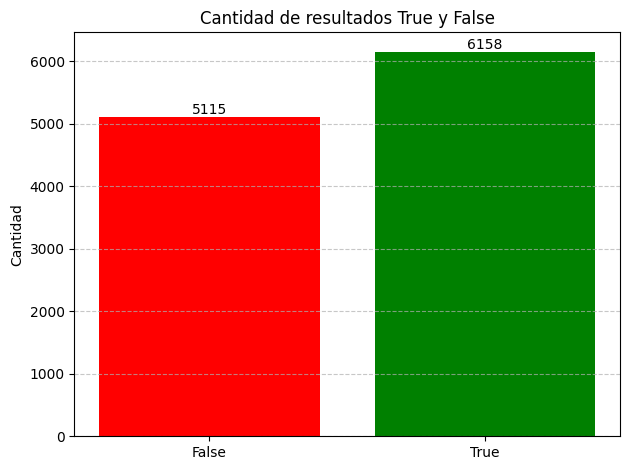

In [ ]:
labels = ['False', 'True']
counts = [false_count, true_count]
colors = ['red', 'green']

plt.bar(labels, counts, color=colors)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.ylabel('Cantidad')
plt.title('Cantidad de resultados True y False')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

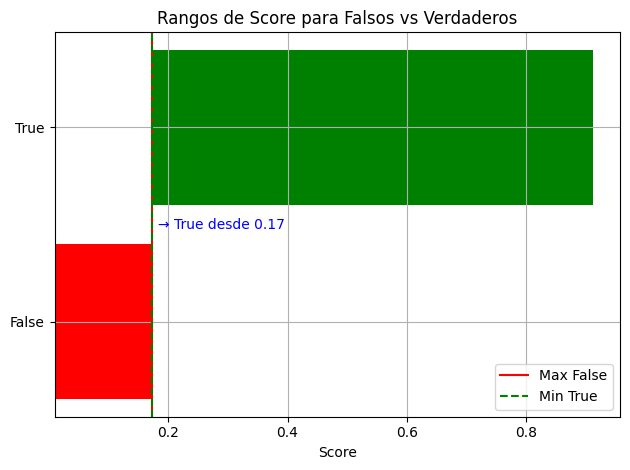

In [ ]:
labels = ['False', 'True']
min_vals = [min_false, min_true]
max_vals = [max_false, max_true]
ranges = [max_val - min_val for min_val, max_val in zip(min_vals, max_vals)]

plt.barh(labels, ranges, left=min_vals, color=['red', 'green'])

plt.axvline(max_false, color='red', linestyle='-', label='Max False')
plt.axvline(min_true, color='green', linestyle='--', label='Min True')

plt.text(min_true + 0.01, 0.5, f"→ True desde {min_true:.2f}", color='blue', va='center')

plt.xlabel('Score')
plt.title('Rangos de Score para Falsos vs Verdaderos')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()